## IMPORTS

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn import linear_model
from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import  cross_val_score

## SETUP

In [102]:
PATH_TRAIN = 'datasets/train.csv'
PATH_TEST = 'datasets/test.csv'

## FUNÇÕES

In [103]:
# Filtra colunas por tipos de dados informados por parâmetro
def obter_lista_de_colunas_por_tipo(dataframe: pd.DataFrame, tipo='nuber') -> list:
    return dataframe.select_dtypes(include=[tipo]).columns

In [104]:
def obter_colunas_com_nulos(dataframe: pd.DataFrame) -> list:
    return dataframe.columns[dataframe.isnull().any()].tolist()

In [105]:
def obter_conj_treinamento_e_teste_estratificado_por(categoria:str, df: pd.DataFrame):
    
    strat_train_set = None
    strat_valid_set = None

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, valid_index in split.split(df, df[categoria]):
        strat_train_set = df.loc[train_index]
        strat_valid_set = df.loc[valid_index]
        
    return strat_train_set, strat_valid_set

In [106]:
def get_dataframe(path: str) -> pd.DataFrame:
    dataframe = pd.read_csv(path)
    return dataframe

## ANÁLISE PRÉVIA DOS DADOS

### Informações gerais

In [107]:
df_train = get_dataframe(path=PATH_TRAIN)
todos_atributos_numericos = obter_lista_de_colunas_por_tipo(df_train, tipo='number')
todos_atributos_categoricos = obter_lista_de_colunas_por_tipo(df_train, tipo='object')

In [108]:
todos_atributos_numericos

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

visualizando as colunas que possuem valores nulos

In [109]:
atributos_numericos_com_valores_numericos_nulos = obter_colunas_com_nulos(df_train[todos_atributos_categoricos])
atributos_numericos_com_valores_numericos_nulos

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

visualizando o percentual de valores nulos

In [110]:
((df_train[atributos_numericos_com_valores_numericos_nulos].isnull().sum() / df_train.shape[0]) * 100).round(2)

Alley           93.77
MasVnrType      59.73
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
PoolQC          99.52
Fence           80.75
MiscFeature     96.30
dtype: float64

Verificando os atributos numéricos que possuem maior correlação com o valor de venda e apresentando apenas aqueles que serão utilizados em um primeiro momento.

In [111]:
atributos_corr_top_5 = (df_train[todos_atributos_numericos].corr()['SalePrice']).sort_values(ascending=False)[:6]
atributos_corr_top_5

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64

### OverallQual

In [112]:
df = df_train[['OverallQual', 'SalePrice']]
df['OverallQual'].value_counts()

OverallQual
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: count, dtype: int64

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

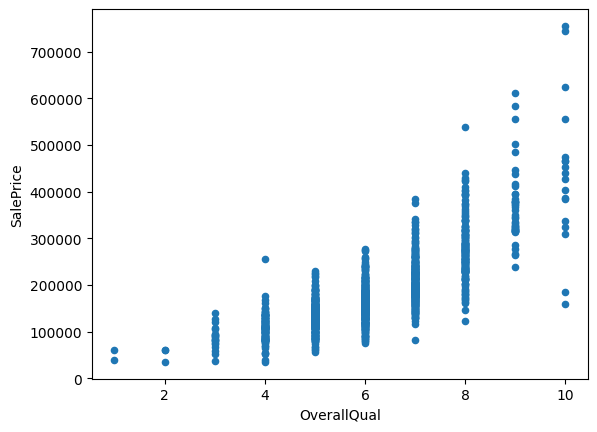

In [113]:
df.plot(kind='scatter', x='OverallQual', y='SalePrice')

Sobre o gráfico de dispersão:

1. Tendência: Positiva
2. Correlação: Forte uma vez que os pontos estão alinhados de forma ascendente. 
3. Distribuição: Há uma variação considerável no SalePrice dentro de uma mesma avaliação
4. Outliers: OverallQual 4, 8, 9 e 10
5. Variabilidade: a uma maior dispersão dos preços em faixas de qualidade mais alta, onde os fatores de diferenciação (como localização, tamanho, idade do imóvel) podem ter um impacto maior.

### GrLivArea

In [114]:
df = get_dataframe(path=PATH_TRAIN)
df = df[['OverallQual', 'GrLivArea', 'SalePrice']]

In [115]:
df.corr()

,OverallQual,GrLivArea,SalePrice
OverallQual,1.000000,0.593007,0.790982
GrLivArea,0.593007,1.000000,0.708624
SalePrice,0.790982,0.708624,1.000000


<Axes: xlabel='SalePrice', ylabel='GrLivArea'>

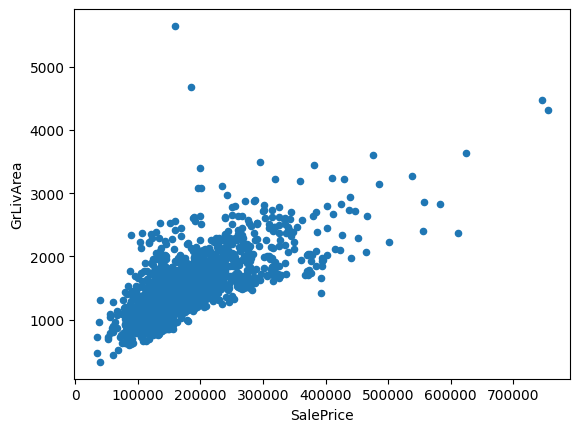

In [116]:
df.plot(kind='scatter', x='SalePrice', y='GrLivArea')

<Axes: xlabel='OverallQual', ylabel='GrLivArea'>

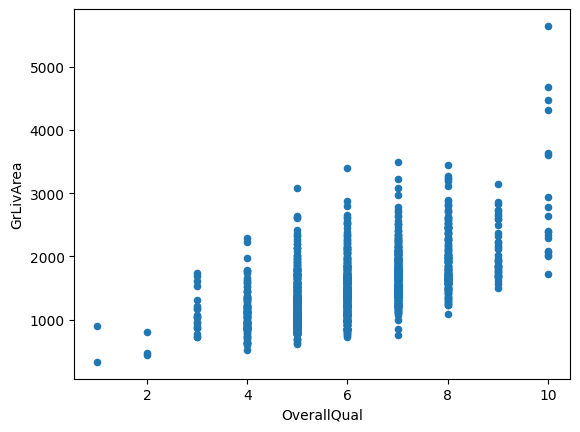

In [117]:
df.plot(kind='scatter', x='OverallQual', y='GrLivArea')

## TREINANDO E AVALIANDO MODELOS

#### SETUP

Definindo a lista de colunas que serão submetidas aos algoritmos de regressão.

In [118]:
X_columns = [
    'OverallQual', 
    'GrLivArea'
]

dummy_columns_pipeline = [
    'OverallQual'
]

In [119]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor, SGDRegressor, TheilSenRegressor, RANSACRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

estimators = [
    LinearRegression(),
    Ridge(alpha=0.5),
    Lasso(alpha=0.1),
    ElasticNet(alpha=0.1, l1_ratio=0.5),
    BayesianRidge(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    ExtraTreesRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    SVR(),
    KNeighborsRegressor(),
    HuberRegressor(),
    PassiveAggressiveRegressor(max_iter=1000, tol=1e-3),
    SGDRegressor(max_iter=1000, tol=1e-3),
    TheilSenRegressor(),
    RANSACRegressor(),
    LGBMRegressor(verbose=-1),
    XGBRegressor()
]

In [120]:
train_set, valid_set = obter_conj_treinamento_e_teste_estratificado_por('OverallQual', get_dataframe(path=PATH_TRAIN))

X_train = train_set[X_columns]
y_train = train_set['SalePrice']

X_valid = valid_set[X_columns]
y_valid = valid_set['SalePrice']

test_set = get_dataframe(path=PATH_TEST)

Para utilizar o root_mean_squared_error na validação cruzada é necessário criar um score personalizado. 

In [121]:
rmse_scorer = make_scorer(root_mean_squared_error)

### AVALIAÇÃO DOS MODELOS EM VALIDAÇÃO CRUZADA

### PIPELINES

In [122]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, KFold

In [123]:
def display_stats(d: dict):
    dataframe = pd.DataFrame.from_dict(d)
    dataframe.sort_values(by=['score', 'std'], ascending=True, inplace=True)
    print(dataframe)

In [124]:
# Pipeline para campos que não serão objeto de processamento
pipeline_dummy = Pipeline([
    ('dummy', SimpleImputer(strategy='median'))
])


pipeline_GrLIveArea = Pipeline([
    ('MinMaxScaler', MinMaxScaler())
])

In [125]:
preprocessor = ColumnTransformer(
    transformers=[
        ('dummy preprocessor', pipeline_dummy, ['OverallQual']),
        ('GrLIveArea', pipeline_GrLIveArea, ['GrLivArea'])
    ]
)

In [126]:
def avaliar_modelos(preprocessor_param: ColumnTransformer, estimators_param: list = estimators):
    
    d = {}
    score_estimator = []
    std_estimator = []
    name_estimator = []

    for estimator_loop in estimators_param:
    
        pipeline = Pipeline(
            steps=[
                ('preprocessor', preprocessor_param),
                (f'{type(estimator_loop).__name__}', estimator_loop)
            ]
        )

        scores = cross_val_score(pipeline, X_train, y_train, scoring=rmse_scorer, cv=10)
        
        score_estimator.append(scores.mean())
        std_estimator.append(scores.std())
        name_estimator.append(type(estimator_loop).__name__)
    
    
    d['estimator'] = name_estimator
    d['score'] = score_estimator
    d['std'] = std_estimator
    
    display_stats(d)
    
        

In [127]:
avaliar_modelos(preprocessor_param=preprocessor, estimators_param=estimators)

                     estimator         score          std
17               LGBMRegressor  37035.479979  4447.024927
11         KNeighborsRegressor  37163.847713  4642.726050
8    GradientBoostingRegressor  37578.946069  6419.041194
9            AdaBoostRegressor  39311.169731  5545.958969
0             LinearRegression  39986.131374  6026.126054
2                        Lasso  39986.162837  6026.062580
4                BayesianRidge  39989.171956  6016.592728
1                        Ridge  40060.114211  5978.120169
6        RandomForestRegressor  40896.099276  5469.770288
15           TheilSenRegressor  41000.737346  5953.135825
12              HuberRegressor  41051.341379  5816.815056
18                XGBRegressor  41446.536219  6421.874720
16             RANSACRegressor  43196.646621  5826.163734
14                SGDRegressor  43498.246544  5589.204619
7          ExtraTreesRegressor  43569.714398  6636.804449
3                   ElasticNet  44269.076010  5046.126719
5        Decis

### Gerando o submit

Fazendo a previsão

In [128]:
X = train_set[X_columns]
y = train_set['SalePrice']

pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('estimator', LGBMRegressor())
    ]
)


pipline.fit(X=X, y=y)
y_predict = pipline.predict(test_set[X_columns])

Gerando o arquivo de submit

In [129]:
test_set['SalePrice'] = y_predict
df_submit = test_set[['Id', 'SalePrice']]
df_submit.to_csv("sumit.csv", index=False)